In [377]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
from plottr.data.datadict_storage import search_datadict
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import copy
import itertools
# import scqubits as scq
import csv
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from lmfit import Model, Parameters

from scipy.optimize import curve_fit


In [378]:

basedir = r"D:/Redza/Logs"
show_plots =True
#Fido function to obtain monitr files
def Fido(datetime, name):          #Fido gets your raw _data for you!
    foldername, datadict = search_datadict(basedir, datetime, name=name , newest = True, only_complete=False)
    print(foldername)
    print(datadict)
    return foldername, datadict

Next, we need to first determine a benchmark which allows us to map our output signal to a corresponding photon number. To do this, perform the 'td-punchout experiment', and fit the results. The aim is to determine $\Omega$.

In [379]:
punchoutFolder, punchoutDict = Fido("2025-09-03T105836", "td_readout_punchout")

amplitude = punchoutDict['amplitude']['values']
frequency =  punchoutDict['frequency']['values'] *1e9
s11 = punchoutDict['s11']['values']

2025-09-03T105836_80d8d21c-td_readout_punchout
s11: (1071,)
  ⌙ frequency (GHz): (1071,)
  ⌙ amplitude (V): (1071,)


In [380]:
#Making an array for based on the points
s11_array = []

for elem in np.arange(len(s11)):
    single_point = []
    single_point.append(frequency[elem])
    single_point.append(amplitude[elem])
    single_point.append(s11[elem])

    s11_array.append(single_point)


x, y, z = zip(*s11_array)

# Convert to arrays
x = np.array(x)
y = np.array(y)
z = np.array(z)

# Assuming structured grid
frequency_vals = np.unique(x)
amplitude_vals = np.unique(y)

# Reshape z to 2D grid
s11_grid= z.reshape(len(amplitude_vals),len(frequency_vals))




'[[Model]]\n    Model(shelving_response)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 61\n    # data points      = 102\n    # variables        = 2\n    chi-square         = 44.5997616\n    reduced chi-square = 0.44599762\n    Akaike info crit   = -80.3789186\n    Bayesian info crit = -75.1289730\n    R-squared          = -4.4600e+16\n[[Variables]]\n    P_ef:   0.55618369 +/- 0.25704548 (46.22%) (init = 0.99)\n    Omega:  1258773.07 +/- 2698028.18 (214.34%) (init = 2.5e+09)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(P_ef, Omega) = +0.8327'

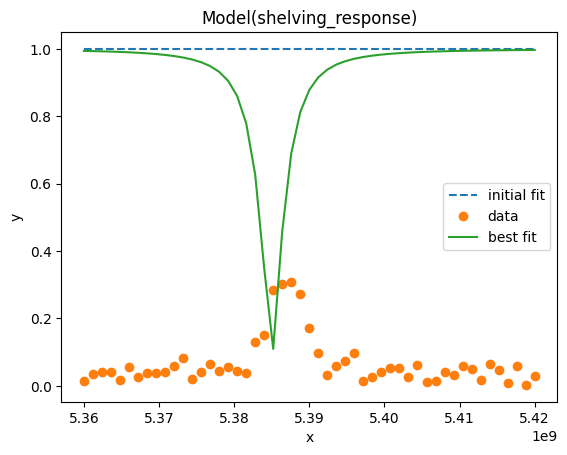

In [381]:
#Constants
Gamma = 5.46e6#Decay rate
w12 = 5.385e9
# P_ef = fluxonium_populations(w01, w12, w23, T)['P1'] + fluxonium_populations(w01, w12, w23, T)['P2']

def shelving_response(x, P_ef, Omega) :
    r = 1 - P_ef * (Gamma*(1j * (x - w12) +(Gamma/2)))/(((x - w12)**2) + (Gamma**2)/4 + (Omega**2))

    return r

index = 20

xdata = np.asarray(frequency_vals)
ydata = np.asarray(s11_grid[index])

#s11 normalization 
ydata = ydata#/ydata[0] 
# print(xdata)
# print(ydata)

LorentzianModel = Model(shelving_response, nan_policy='omit')
 
params = LorentzianModel.make_params(
                                P_ef = dict(value = 0.99, min = 0.2, max = 1),
                                Omega = dict(value = 2.50e9),)
                                # Gamma = dict(value = 5.46e6))


result = LorentzianModel.fit(ydata, params, x = xdata, method = 'leastsq')
result.plot_fit(show_init=True)
result.fit_report()